In [1]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r'C:\Users\Admin\Documents\Capstone Project\IBM Churn.csv')

# Impute Missing Value

In [3]:
charges = list(df['TotalCharges'])
charges = [x for x in charges if x != ' ']
charges = [float(x) for x in charges if x != ' ']

In [4]:
charges_mean = np.mean(charges)
df['TotalCharges'] = df['TotalCharges'].apply(lambda x: charges_mean if x == ' ' else x)
df['TotalCharges'] = df['TotalCharges'].astype(float)

# Log Transformation

In [5]:
columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

for column in columns:
  df[column+'_log'] = np.log(df[column]+0.1)

# Clustering Analysis

In [6]:
def silhouette_check_agglo(df,columns):
  range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  silhouette_list = []
  cluster_list = []

  for n_clusters in range_n_clusters:
      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.
      from sklearn.cluster import AgglomerativeClustering
      cluster_list.append(n_clusters)
      cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')  
      cluster_labels = cluster.fit_predict(df[columns])

      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(df[columns], cluster_labels)
      silhouette_list.append(silhouette_avg)
      print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)
      
  plt.plot(cluster_list,silhouette_list)  

columns = ['tenure_log', 'TotalCharges_log']

For n_clusters = 2 The average silhouette_score is : 0.5347265743958682
For n_clusters = 3 The average silhouette_score is : 0.5427650095498794
For n_clusters = 4 The average silhouette_score is : 0.4472177089760178
For n_clusters = 5 The average silhouette_score is : 0.4245225654540812
For n_clusters = 6 The average silhouette_score is : 0.4167733103786472
For n_clusters = 7 The average silhouette_score is : 0.4250772730023145
For n_clusters = 8 The average silhouette_score is : 0.4490332653043902
For n_clusters = 9 The average silhouette_score is : 0.45098005975529787
For n_clusters = 10 The average silhouette_score is : 0.4399664584214938
For n_clusters = 11 The average silhouette_score is : 0.4532618285407518
For n_clusters = 12 The average silhouette_score is : 0.4725749008354397


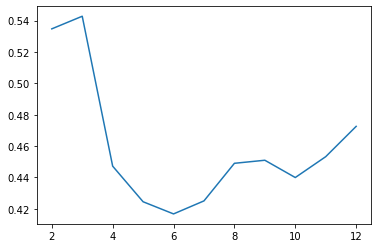

In [7]:
silhouette_check_agglo(df,columns)

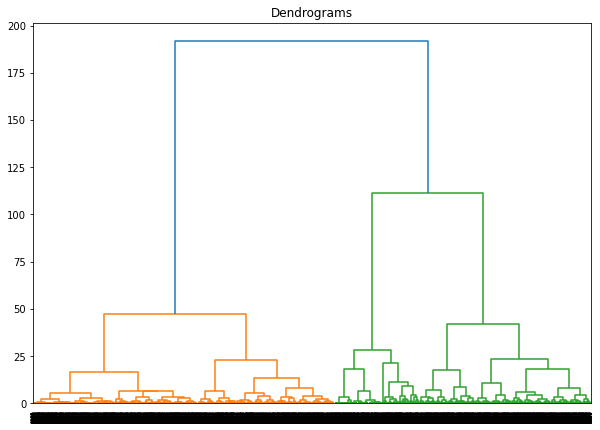

In [8]:
columns = ['tenure_log', 'TotalCharges_log']
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df[columns], method='ward'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cust_val_cluster = cluster.fit_predict(df[columns])

In [ ]:
columns = ['MonthlyCharges_log', 'TotalCharges_log']

In [ ]:
silhouette_check_agglo(df,columns)

In [ ]:
columns = ['MonthlyCharges_log', 'TotalCharges_log']
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df[columns], method='ward'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
month_vs_total_cluster = cluster.fit_predict(df[columns])

In [ ]:
df['cust_val_cluster'] = cust_val_cluster
df['month_vs_total_cluster'] = month_vs_total_cluster

# Association Rule Mining

In [ ]:
df_sel = df[['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn',
       'cust_val_cluster', 'month_vs_total_cluster']]

In [ ]:
df_sel = df_sel.melt(id_vars=['customerID'], var_name='event',
             value_name='event type')

In [ ]:
cols = ['event', 'event type']
df_sel['new event'] = df_sel[cols].apply(lambda row: ': '.join(row.values.astype(str)), axis=1)

In [ ]:
df_sel['Indicator'] = 1

In [ ]:
mybasket = (df_sel.groupby(['customerID','new event'])['Indicator'].sum().unstack().reset_index().fillna(0).set_index('customerID'))

In [ ]:
def my_encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

my_basket_sets = mybasket.applymap(my_encode_units)

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
#Generatig frequent itemsets
my_frequent_itemsets = apriori(my_basket_sets, min_support=0.05, use_colnames=True, max_len = 3)

In [ ]:
my_frequent_itemsets.sort_values(['support'], ascending =[False])

In [ ]:
rules = association_rules(my_frequent_itemsets, metric = 'lift', 
                          min_threshold = 1.0)

In [ ]:
churn_rules = rules.loc[rules['antecedents'] == frozenset({'Churn: Yes'}) ].sort_values(['support'], ascending =[False])

In [ ]:
np.median(churn_rules['lift'])

In [ ]:
new_list = [list(x) for x in churn_rules.loc[churn_rules['lift'] >= 1.5214123549743264]['consequents']]

In [ ]:
churn_rules_support_df = pd.DataFrame(new_list).rename(columns = {0 : 'First', 1 : 'Second'})

In [ ]:
churn_lift = churn_rules.loc[churn_rules['lift'] >= 1.5214123549743264][['lift','support']].reset_index()
churn_rules_support_df['lift'] = churn_lift['lift']
churn_rules_support_df['support'] = churn_lift['support']
churn_rules_support_df.loc[churn_rules_support_df['Second'].isnull() == False].head(50)

In [ ]:
new_list_lift = [list(x) for x in churn_rules.loc[churn_rules['lift'] >= 1.5214123549743264].sort_values(['lift'], ascending =[False])['consequents']]

In [ ]:
churn_rules_lift_df = pd.DataFrame(new_list_lift).rename(columns = {0 : 'First', 1 : 'Second'})

In [ ]:
churn_lift_lift = churn_rules.loc[churn_rules['lift'] >= 1.5214123549743264].sort_values(['lift'], ascending =[False])[['lift','support']].reset_index()
churn_rules_lift_df['lift'] = churn_lift_lift ['lift']
churn_rules_lift_df['support'] = churn_lift_lift ['support']
churn_rules_lift_df.head(50)

# WoE Encoding

In [9]:
df.Churn = df.Churn.apply(lambda x: 1 if x == 'Yes' else 0 )
CON_PS = df.groupby(['Contract','PhoneService'])['Churn'].mean()
CON_PS = pd.DataFrame(CON_PS)

CON_PS = CON_PS.rename(columns = {'Churn':'Churn'})
CON_PS['not churn'] = 1-CON_PS.Churn
CON_PS['Churn'] = np.where(CON_PS['Churn']  == 0, 0.00001, CON_PS['Churn'])
CON_PS['not churn'] = np.where(CON_PS['not churn']  == 0, 0.00001, CON_PS['not churn'])
CON_PS['CON_PS_WoE'] = np.log(CON_PS.Churn/CON_PS['not churn'])
CON_PS.reset_index(inplace=True)
CON_PS = CON_PS[['Contract','PhoneService','CON_PS_WoE']]
CON_PS

,Contract,PhoneService,CON_PS_WoE
0,Month-to-month,No,-0.376734
1,Month-to-month,Yes,-0.284849
2,One year,No,-2.236140
3,One year,Yes,-2.045994
4,Two year,No,-3.963983
5,Two year,Yes,-3.499198


In [10]:
CON_DEP = df.groupby(['Contract','Dependents'])['Churn'].mean()
CON_DEP = pd.DataFrame(CON_DEP)

CON_DEP = CON_DEP.rename(columns = {'Churn':'Churn'})
CON_DEP['not churn'] = 1-CON_DEP.Churn
CON_DEP['Churn'] = np.where(CON_DEP['Churn']  == 0, 0.00001, CON_DEP['Churn'])
CON_DEP['not churn'] = np.where(CON_DEP['not churn']  == 0, 0.00001, CON_DEP['not churn'])
CON_DEP['CON_DEP_WoE'] = np.log(CON_DEP.Churn/CON_DEP['not churn'])
CON_DEP.reset_index(inplace=True)
CON_DEP = CON_DEP[['Contract','Dependents','CON_DEP_WoE']]
CON_DEP

,Contract,Dependents,CON_DEP_WoE
0,Month-to-month,No,-0.191118
1,Month-to-month,Yes,-0.716049
2,One year,No,-1.953209
3,One year,Yes,-2.286124
4,Two year,No,-3.373027
5,Two year,Yes,-3.758613


In [11]:
CON_TS = df.groupby(['Contract','TechSupport'])['Churn'].mean()
CON_TS = pd.DataFrame(CON_TS)

CON_TS = CON_TS.rename(columns = {'Churn':'Churn'})
CON_TS['not churn'] = 1-CON_TS.Churn
CON_TS['Churn'] = np.where(CON_TS['Churn']  == 0, 0.00001, CON_TS['Churn'])
CON_TS['not churn'] = np.where(CON_TS['not churn']  == 0, 0.00001, CON_TS['not churn'])
CON_TS['CON_TS_WoE'] = np.log(CON_TS.Churn/CON_TS['not churn'])
CON_TS.reset_index(inplace=True)
CON_TS = CON_TS[['Contract','TechSupport','CON_TS_WoE']]
CON_TS

,Contract,TechSupport,CON_TS_WoE
0,Month-to-month,No,0.014926
1,Month-to-month,No internet service,-1.456969
2,Month-to-month,Yes,-0.814161
3,One year,No,-1.756596
4,One year,No internet service,-3.674893
5,One year,Yes,-1.850028
6,Two year,No,-2.763620
7,Two year,No internet service,-4.841033
8,Two year,Yes,-3.307266


In [ ]:
CON_OS = df.groupby(['Contract','OnlineSecurity'])['Churn'].mean()
CON_OS = pd.DataFrame(CON_OS)

CON_OS = CON_OS.rename(columns = {'Churn':'Churn'})
CON_OS['not churn'] = 1-CON_OS.Churn
CON_OS['Churn'] = np.where(CON_OS['Churn']  == 0, 0.00001, CON_OS['Churn'])
CON_OS['not churn'] = np.where(CON_OS['not churn']  == 0, 0.00001, CON_OS['not churn'])
CON_OS['CON_OS_WoE'] = np.log(CON_OS.Churn/CON_OS['not churn'])
CON_OS.reset_index(inplace=True)
CON_OS = CON_OS[['Contract','OnlineSecurity','CON_OS_WoE']]
CON_OS

In [ ]:
PS_OS = df.groupby(['PhoneService','OnlineSecurity'])['Churn'].mean()
PS_OS = pd.DataFrame(PS_OS)

PS_OS = PS_OS.rename(columns = {'Churn':'Churn'})
PS_OS['not churn'] = 1-PS_OS.Churn
PS_OS['Churn'] = np.where(PS_OS['Churn']  == 0, 0.00001, PS_OS['Churn'])
PS_OS['not churn'] = np.where(PS_OS['not churn']  == 0, 0.00001, PS_OS['not churn'])
PS_OS['PS_OS_WoE'] = np.log(PS_OS.Churn/PS_OS['not churn'])
PS_OS.reset_index(inplace=True)
PS_OS = PS_OS[['PhoneService','OnlineSecurity','PS_OS_WoE']]
PS_OS

In [ ]:
PS_TS = df.groupby(['PhoneService','TechSupport'])['Churn'].mean()
PS_TS = pd.DataFrame(PS_TS)

PS_TS = PS_TS.rename(columns = {'Churn':'Churn'})
PS_TS['not churn'] = 1-PS_TS.Churn
PS_TS['Churn'] = np.where(PS_TS['Churn']  == 0, 0.00001, PS_TS['Churn'])
PS_TS['not churn'] = np.where(PS_TS['not churn']  == 0, 0.00001, PS_TS['not churn'])
PS_TS['PS_TS_WoE'] = np.log(PS_TS.Churn/PS_TS['not churn'])
PS_TS.reset_index(inplace=True)
PS_TS = PS_TS[['PhoneService','TechSupport','PS_TS_WoE']]
PS_TS

In [ ]:
PS_IS = df.groupby(['PhoneService','InternetService'])['Churn'].mean()
PS_IS = pd.DataFrame(PS_IS)

PS_IS = PS_IS.rename(columns = {'Churn':'Churn'})
PS_IS['not churn'] = 1-PS_IS.Churn
PS_IS['Churn'] = np.where(PS_IS['Churn']  == 0, 0.00001, PS_IS['Churn'])
PS_IS['not churn'] = np.where(PS_IS['not churn']  == 0, 0.00001, PS_IS['not churn'])
PS_IS['PS_IS_WoE'] = np.log(PS_IS.Churn/PS_IS['not churn'])
PS_IS.reset_index(inplace=True)
PS_IS = PS_IS[['PhoneService','InternetService','PS_IS_WoE']]
PS_IS

In [ ]:
TS_OS = df.groupby(['TechSupport','OnlineSecurity'])['Churn'].mean()
TS_OS = pd.DataFrame(TS_OS)

TS_OS = TS_OS.rename(columns = {'Churn':'Churn'})
TS_OS['not churn'] = 1-TS_OS.Churn
TS_OS['Churn'] = np.where(TS_OS['Churn']  == 0, 0.00001, TS_OS['Churn'])
TS_OS['not churn'] = np.where(TS_OS['not churn']  == 0, 0.00001, TS_OS['not churn'])
TS_OS['TS_OS_WoE'] = np.log(TS_OS.Churn/TS_OS['not churn'])
TS_OS.reset_index(inplace=True)
TS_OS = TS_OS[['TechSupport','OnlineSecurity','TS_OS_WoE']]
TS_OS

In [ ]:
PB_CON = df.groupby(['PaperlessBilling','Contract'])['Churn'].mean()
PB_CON = pd.DataFrame(PB_CON)

PB_CON = PB_CON.rename(columns = {'Churn':'Churn'})
PB_CON['not churn'] = 1-PB_CON.Churn
PB_CON['Churn'] = np.where(PB_CON['Churn']  == 0, 0.00001, PB_CON['Churn'])
PB_CON['not churn'] = np.where(PB_CON['not churn']  == 0, 0.00001, PB_CON['not churn'])
PB_CON['PB_CON_WoE'] = np.log(PB_CON.Churn/PB_CON['not churn'])
PB_CON.reset_index(inplace=True)
PB_CON = PB_CON[['PaperlessBilling','Contract','PB_CON_WoE']]
PB_CON

In [ ]:
OS_DEP = df.groupby(['OnlineSecurity','Dependents'])['Churn'].mean()
OS_DEP = pd.DataFrame(OS_DEP)

OS_DEP = OS_DEP.rename(columns = {'Churn':'Churn'})
OS_DEP['not churn'] = 1-OS_DEP.Churn
OS_DEP['Churn'] = np.where(OS_DEP['Churn']  == 0, 0.00001, OS_DEP['Churn'])
OS_DEP['not churn'] = np.where(OS_DEP['not churn']  == 0, 0.00001, OS_DEP['not churn'])
OS_DEP['OS_DEP_WoE'] = np.log(OS_DEP.Churn/OS_DEP['not churn'])
OS_DEP.reset_index(inplace=True)
OS_DEP = OS_DEP[['OnlineSecurity','Dependents','OS_DEP_WoE']]
OS_DEP

In [ ]:
CV_OS = df.groupby(['cust_val_cluster','OnlineSecurity'])['Churn'].mean()
CV_OS = pd.DataFrame(CV_OS)

CV_OS = CV_OS.rename(columns = {'Churn':'Churn'})
CV_OS['not churn'] = 1-CV_OS.Churn
CV_OS['Churn'] = np.where(CV_OS['Churn']  == 0, 0.00001, CV_OS['Churn'])
CV_OS['not churn'] = np.where(CV_OS['not churn']  == 0, 0.00001, CV_OS['not churn'])
CV_OS['CV_OS_WoE'] = np.log(CV_OS.Churn/CV_OS['not churn'])
CV_OS.reset_index(inplace=True)
CV_OS = CV_OS[['cust_val_cluster','OnlineSecurity','CV_OS_WoE']]
CV_OS

In [ ]:
CV_TS = df.groupby(['cust_val_cluster','TechSupport'])['Churn'].mean()
CV_TS = pd.DataFrame(CV_TS)

CV_TS = CV_TS.rename(columns = {'Churn':'Churn'})
CV_TS['not churn'] = 1-CV_TS.Churn
CV_TS['Churn'] = np.where(CV_TS['Churn']  == 0, 0.00001, CV_TS['Churn'])
CV_TS['not churn'] = np.where(CV_TS['not churn']  == 0, 0.00001, CV_TS['not churn'])
CV_TS['CV_TS_WoE'] = np.log(CV_TS.Churn/CV_TS['not churn'])
CV_TS.reset_index(inplace=True)
CV_TS = CV_TS[['cust_val_cluster','TechSupport','CV_TS_WoE']]
CV_TS

In [ ]:
MVT_IS = df.groupby(['month_vs_total_cluster','InternetService'])['Churn'].mean()
MVT_IS = pd.DataFrame(MVT_IS)

MVT_IS = MVT_IS.rename(columns = {'Churn':'Churn'})
MVT_IS['not churn'] = 1-MVT_IS.Churn
MVT_IS['Churn'] = np.where(MVT_IS['Churn']  == 0, 0.00001, MVT_IS['Churn'])
MVT_IS['not churn'] = np.where(MVT_IS['not churn']  == 0, 0.00001, MVT_IS['not churn'])
MVT_IS['MVT_IS_WoE'] = np.log(MVT_IS.Churn/MVT_IS['not churn'])
MVT_IS.reset_index(inplace=True)
MVT_IS = MVT_IS[['month_vs_total_cluster','InternetService','MVT_IS_WoE']]
MVT_IS

In [ ]:
CV_OB = df.groupby(['cust_val_cluster','OnlineBackup'])['Churn'].mean()
CV_OB = pd.DataFrame(CV_OB)

CV_OB = CV_OB.rename(columns = {'Churn':'Churn'})
CV_OB['not churn'] = 1-CV_OB.Churn
CV_OB['Churn'] = np.where(CV_OB['Churn']  == 0, 0.00001, CV_OB['Churn'])
CV_OB['not churn'] = np.where(CV_OB['not churn']  == 0, 0.00001, CV_OB['not churn'])
CV_OB['CV_OB_WoE'] = np.log(CV_OB.Churn/CV_OB['not churn'])
CV_OB.reset_index(inplace=True)
CV_OB = CV_OB[['cust_val_cluster','OnlineBackup','CV_OB_WoE']]
CV_OB

In [ ]:
CV_DP = df.groupby(['cust_val_cluster','DeviceProtection'])['Churn'].mean()
CV_DP = pd.DataFrame(CV_DP)

CV_DP = CV_DP.rename(columns = {'Churn':'Churn'})
CV_DP['not churn'] = 1-CV_DP.Churn
CV_DP['Churn'] = np.where(CV_DP['Churn']  == 0, 0.00001, CV_DP['Churn'])
CV_DP['not churn'] = np.where(CV_DP['not churn']  == 0, 0.00001, CV_DP['not churn'])
CV_DP['CV_DP_WoE'] = np.log(CV_DP.Churn/CV_DP['not churn'])
CV_DP.reset_index(inplace=True)
CV_DP = CV_DP[['cust_val_cluster','DeviceProtection','CV_DP_WoE']]
CV_DP

In [ ]:
CV_PB = df.groupby(['cust_val_cluster','PaperlessBilling'])['Churn'].mean()
CV_PB = pd.DataFrame(CV_PB)

CV_PB = CV_PB.rename(columns = {'Churn':'Churn'})
CV_PB['not churn'] = 1-CV_PB.Churn
CV_PB['Churn'] = np.where(CV_PB['Churn']  == 0, 0.00001, CV_PB['Churn'])
CV_PB['not churn'] = np.where(CV_PB['not churn']  == 0, 0.00001, CV_PB['not churn'])
CV_PB['CV_PB_WoE'] = np.log(CV_PB.Churn/CV_PB['not churn'])
CV_PB.reset_index(inplace=True)
CV_PB = CV_PB[['cust_val_cluster','PaperlessBilling','CV_PB_WoE']]
CV_PB

In [ ]:
CV_ST = df.groupby(['cust_val_cluster','StreamingTV'])['Churn'].mean()
CV_ST = pd.DataFrame(CV_ST)

CV_ST = CV_ST.rename(columns = {'Churn':'Churn'})
CV_ST['not churn'] = 1-CV_ST.Churn
CV_ST['Churn'] = np.where(CV_ST['Churn']  == 0, 0.00001, CV_ST['Churn'])
CV_ST['not churn'] = np.where(CV_ST['not churn']  == 0, 0.00001, CV_ST['not churn'])
CV_ST['CV_ST_WoE'] = np.log(CV_ST.Churn/CV_ST['not churn'])
CV_ST.reset_index(inplace=True)
CV_ST = CV_ST[['cust_val_cluster','StreamingTV','CV_ST_WoE']]
CV_ST

In [ ]:
CV_SM = df.groupby(['cust_val_cluster','StreamingMovies'])['Churn'].mean()
CV_SM = pd.DataFrame(CV_SM)

CV_SM = CV_SM.rename(columns = {'Churn':'Churn'})
CV_SM['not churn'] = 1-CV_SM.Churn
CV_SM['Churn'] = np.where(CV_SM['Churn']  == 0, 0.00001, CV_SM['Churn'])
CV_SM['not churn'] = np.where(CV_SM['not churn']  == 0, 0.00001, CV_SM['not churn'])
CV_SM['CV_SM_WoE'] = np.log(CV_SM.Churn/CV_SM['not churn'])
CV_SM.reset_index(inplace=True)
CV_SM = CV_SM[['cust_val_cluster','StreamingMovies','CV_SM_WoE']]
CV_SM

In [ ]:
CV_IS = df.groupby(['cust_val_cluster','InternetService'])['Churn'].mean()
CV_IS = pd.DataFrame(CV_IS)

CV_IS = CV_IS.rename(columns = {'Churn':'Churn'})
CV_IS['not churn'] = 1-CV_IS.Churn
CV_IS['Churn'] = np.where(CV_IS['Churn']  == 0, 0.00001, CV_IS['Churn'])
CV_IS['not churn'] = np.where(CV_IS['not churn']  == 0, 0.00001, CV_IS['not churn'])
CV_IS['CV_IS_WoE'] = np.log(CV_IS.Churn/CV_IS['not churn'])
CV_IS.reset_index(inplace=True)
CV_IS = CV_IS[['cust_val_cluster','InternetService','CV_IS_WoE']]
CV_IS

In [ ]:
MVT_PM = df.groupby(['month_vs_total_cluster','PaymentMethod'])['Churn'].mean()
MVT_PM = pd.DataFrame(MVT_PM)

MVT_PM = MVT_PM.rename(columns = {'Churn':'Churn'})
MVT_PM['not churn'] = 1-MVT_PM.Churn
MVT_PM['Churn'] = np.where(MVT_PM['Churn']  == 0, 0.00001, MVT_PM['Churn'])
MVT_PM['not churn'] = np.where(MVT_PM['not churn']  == 0, 0.00001, MVT_PM['not churn'])
MVT_PM['MVT_PM_WoE'] = np.log(MVT_PM.Churn/MVT_PM['not churn'])
MVT_PM.reset_index(inplace=True)
MVT_PM = MVT_PM[['month_vs_total_cluster','PaymentMethod','MVT_PM_WoE']]
MVT_PM

In [ ]:
CV_PM = df.groupby(['cust_val_cluster','PaymentMethod'])['Churn'].mean()
CV_PM = pd.DataFrame(CV_PM)

CV_PM = CV_PM.rename(columns = {'Churn':'Churn'})
CV_PM['not churn'] = 1-CV_PM.Churn
CV_PM['Churn'] = np.where(CV_PM['Churn']  == 0, 0.00001, CV_PM['Churn'])
CV_PM['not churn'] = np.where(CV_PM['not churn']  == 0, 0.00001, CV_PM['not churn'])
CV_PM['CV_PM_WoE'] = np.log(CV_PM.Churn/CV_PM['not churn'])
CV_PM.reset_index(inplace=True)
CV_PM = CV_PM[['cust_val_cluster','PaymentMethod','CV_PM_WoE']]
CV_PM

In [ ]:
CON_ST = df.groupby(['Contract','StreamingTV'])['Churn'].mean()
CON_ST = pd.DataFrame(CON_ST)

CON_ST = CON_ST.rename(columns = {'Churn':'Churn'})
CON_ST['not churn'] = 1-CON_ST.Churn
CON_ST['Churn'] = np.where(CON_ST['Churn']  == 0, 0.00001, CON_ST['Churn'])
CON_ST['not churn'] = np.where(CON_ST['not churn']  == 0, 0.00001, CON_ST['not churn'])
CON_ST['CON_ST_WoE'] = np.log(CON_ST.Churn/CON_ST['not churn'])
CON_ST.reset_index(inplace=True)
CON_ST = CON_ST[['Contract','StreamingTV','CON_ST_WoE']]
CON_ST

In [ ]:
CON_SM = df.groupby(['Contract','StreamingMovies'])['Churn'].mean()
CON_SM = pd.DataFrame(CON_SM)

CON_SM = CON_SM.rename(columns = {'Churn':'Churn'})
CON_SM['not churn'] = 1-CON_SM.Churn
CON_SM['Churn'] = np.where(CON_SM['Churn']  == 0, 0.00001, CON_SM['Churn'])
CON_SM['not churn'] = np.where(CON_SM['not churn']  == 0, 0.00001, CON_SM['not churn'])
CON_SM['CON_SM_WoE'] = np.log(CON_SM.Churn/CON_SM['not churn'])
CON_SM.reset_index(inplace=True)
CON_SM = CON_SM[['Contract','StreamingMovies','CON_SM_WoE']]
CON_SM

In [ ]:
CON_SC = df.groupby(['Contract','SeniorCitizen'])['Churn'].mean()
CON_SC = pd.DataFrame(CON_SC)

CON_SC = CON_SC.rename(columns = {'Churn':'Churn'})
CON_SC['not churn'] = 1-CON_SC.Churn
CON_SC['Churn'] = np.where(CON_SC['Churn']  == 0, 0.00001, CON_SC['Churn'])
CON_SC['not churn'] = np.where(CON_SC['not churn']  == 0, 0.00001, CON_SC['not churn'])
CON_SC['CON_SC_WoE'] = np.log(CON_SC.Churn/CON_SC['not churn'])
CON_SC.reset_index(inplace=True)
CON_SC = CON_SC[['Contract','SeniorCitizen','CON_SC_WoE']]
CON_SC

In [ ]:
df_woe = df.merge(CON_PS, on=['Contract','PhoneService'])
df_woe = df_woe.merge(CON_DEP, on=['Contract','Dependents'])
df_woe = df_woe.merge(CON_TS, on=['Contract','TechSupport'])
df_woe = df_woe.merge(CON_OS, on=['Contract','OnlineSecurity'])
df_woe = df_woe.merge(PS_OS, on=['PhoneService','OnlineSecurity'])


df_woe = df_woe.merge(PS_TS, on=['PhoneService','TechSupport'])
df_woe = df_woe.merge(PS_IS, on=['PhoneService','InternetService'])
df_woe = df_woe.merge(TS_OS, on=['TechSupport','OnlineSecurity'])
df_woe = df_woe.merge(PB_CON, on=['PaperlessBilling','Contract'])
df_woe = df_woe.merge(OS_DEP, on=['OnlineSecurity','Dependents'])


df_woe = df_woe.merge(CV_OS, on=['cust_val_cluster','OnlineSecurity'])
df_woe = df_woe.merge(CV_TS, on=['cust_val_cluster','TechSupport'])
df_woe = df_woe.merge(MVT_IS, on=['month_vs_total_cluster','InternetService'])
df_woe = df_woe.merge(CV_OB, on=['cust_val_cluster','OnlineBackup'])
df_woe = df_woe.merge(CV_DP, on=['cust_val_cluster','DeviceProtection'])

df_woe = df_woe.merge(CV_PB, on=['cust_val_cluster','PaperlessBilling'])
df_woe = df_woe.merge(CV_ST, on=['cust_val_cluster','StreamingTV'])
df_woe = df_woe.merge(CV_SM, on=['cust_val_cluster','StreamingMovies'])
df_woe = df_woe.merge(CV_IS, on=['cust_val_cluster','InternetService'])
df_woe = df_woe.merge(MVT_PM, on=['month_vs_total_cluster','PaymentMethod'])

df_woe = df_woe.merge(CV_PM, on=['cust_val_cluster','PaymentMethod'])
df_woe = df_woe.merge(CON_ST, on=['Contract','StreamingTV'])
df_woe = df_woe.merge(CON_SM, on=['Contract','StreamingMovies'])
df_woe = df_woe.merge(CON_SC, on=['Contract','SeniorCitizen'])


# Model Training (With customer profiling data) -with feature selection and imbalanced dataset handling

In [ ]:
dfx = df_woe.drop(columns = ['Churn'])
dfy = df_woe.Churn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=88)

In [ ]:
X_train['Churn'] = y_train
X_test['Churn'] = y_test

In [ ]:
#X_train.to_csv(r'C:\Users\Admin\Documents\Capstone Project\Experiment 104\xy_train_20210830.csv', index = False)
#X_test.to_csv(r'C:\Users\Admin\Documents\Capstone Project\Experiment 104\xy_test_20210830.csv', index = False)

In [ ]:
df_train = X_train[['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Satisfaction Score',
       'Churn', 'tenure_log', 'MonthlyCharges_log', 'TotalCharges_log',
       'cust_val_cluster', 'month_vs_total_cluster', 'CON_PS_WoE',
       'CON_DEP_WoE', 'CON_TS_WoE', 'CON_OS_WoE', 'PS_OS_WoE', 'PS_TS_WoE',
       'PS_IS_WoE', 'TS_OS_WoE', 'PB_CON_WoE', 'OS_DEP_WoE', 'CV_OS_WoE',
       'CV_TS_WoE', 'MVT_IS_WoE', 'CV_OB_WoE', 'CV_DP_WoE', 'CV_PB_WoE_x',
       'CV_ST_WoE_x', 'CV_SM_WoE_x', 'CV_IS_WoE_x', 'CV_PB_WoE_y',
       'CV_ST_WoE_y', 'CV_SM_WoE_y', 'CV_IS_WoE_y', 'MVT_PM_WoE', 'CV_PM_WoE',
       'CON_ST_WoE', 'CON_SM_WoE', 'CON_SC_WoE']]

df_test = X_test[['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Satisfaction Score',
       'Churn', 'tenure_log', 'MonthlyCharges_log', 'TotalCharges_log',
       'cust_val_cluster', 'month_vs_total_cluster', 'CON_PS_WoE',
       'CON_DEP_WoE', 'CON_TS_WoE', 'CON_OS_WoE', 'PS_OS_WoE', 'PS_TS_WoE',
       'PS_IS_WoE', 'TS_OS_WoE', 'PB_CON_WoE', 'OS_DEP_WoE', 'CV_OS_WoE',
       'CV_TS_WoE', 'MVT_IS_WoE', 'CV_OB_WoE', 'CV_DP_WoE', 'CV_PB_WoE_x',
       'CV_ST_WoE_x', 'CV_SM_WoE_x', 'CV_IS_WoE_x', 'CV_PB_WoE_y',
       'CV_ST_WoE_y', 'CV_SM_WoE_y', 'CV_IS_WoE_y', 'MVT_PM_WoE', 'CV_PM_WoE',
       'CON_ST_WoE', 'CON_SM_WoE', 'CON_SC_WoE']]


In [ ]:
from pycaret.classification import *

In [ ]:
from imblearn.over_sampling import ADASYN
clf1 = setup(data = df_train, target = 'Churn', test_data = df_test,
             feature_selection = True, feature_selection_threshold = 0.7, feature_selection_method = 'boruta',
             ignore_features = ['customerID','CV_PB_WoE_y',
       'CV_ST_WoE_y', 'CV_SM_WoE_y', 'CV_IS_WoE_y','Satisfaction Score', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Satisfaction Score'], 
            fix_imbalance=True, fix_imbalance_method= ADASYN()
            )

# Model LR-CP

In [ ]:
lr = create_model('lr')
tuned_lr = tune_model(lr, n_iter = 200, fold = 5, optimize = 'F1')

# Model RF-CP

In [ ]:
rf = create_model('rf')
tuned_rf = tune_model(rf, n_iter = 200, fold = 5, optimize = 'F1')

# Model GBC-CP

In [ ]:
gbc = create_model('gbc')
tuned_gbc = tune_model(gbc, n_iter = 200, fold = 5, optimize = 'F1')

# Model LGBM-CP

In [ ]:
lgb = create_model('lightgbm')
tuned_lgb = tune_model(lgb, n_iter = 200, fold = 5, optimize = 'F1')

# Model XGB-CP

In [ ]:
xgb = create_model('xgboost')
tuned_xgb = tune_model(xgb, n_iter = 200, fold = 5, optimize = 'F1')

# Model SVM-CP

In [ ]:
svm = create_model('rbfsvm')
tuned_svm = tune_model(svm, n_iter = 200, fold = 5, optimize = 'F1')

# Model Evaluation (Models with Customer Profiling Data)

In [ ]:
evaluate_model(tuned_lr)

In [ ]:
evaluate_model(tuned_rf)

In [ ]:
evaluate_model(tuned_gbc)

In [ ]:
evaluate_model(tuned_lgb)

In [ ]:
evaluate_model(tuned_xgb)

In [ ]:
evaluate_model(tuned_svm)

# Model Training (Without customer profiling data) -with feature selection and imbalanced dataset handling

In [ ]:
train = pd.read_csv(r'C:\Users\Admin\Documents\Capstone Project\Experiment 104\xy_train_20210830.csv')
test = pd.read_csv(r'C:\Users\Admin\Documents\Capstone Project\Experiment 104\xy_test_20210830.csv')

In [ ]:
df_train = train[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges','Churn']]

df_test = test[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges','Churn']]

In [ ]:
from imblearn.over_sampling import ADASYN
clf1 = setup(data = df_train, target = 'Churn', test_data = df_test, normalize = True, 
             feature_selection = True, feature_selection_threshold = 0.7, feature_selection_method = 'boruta',
             
            fix_imbalance=True, fix_imbalance_method= ADASYN()
            )

# Model LR

In [ ]:
lr = create_model('lr')
tuned_lr = tune_model(lr, n_iter = 200, fold = 5, optimize = 'F1')

# Model RF

In [ ]:
rf = create_model('rf')
tuned_rf = tune_model(rf, n_iter = 200, fold = 5, optimize = 'F1')

# Model GBC

In [ ]:
gbc = create_model('gbc')
tuned_gbc = tune_model(gbc, n_iter = 200, fold = 5, optimize = 'F1')

# Model LGB

In [ ]:
lgb = create_model('lightgbm')
tuned_lgb = tune_model(lgb, n_iter = 200, fold = 5, optimize = 'F1')

# Model XGB

In [ ]:
xgb = create_model('xgboost')
tuned_xgb = tune_model(xgb, n_iter = 200, fold = 5, optimize = 'F1')

# Model SVM

In [ ]:
svm = create_model('rbfsvm')
tuned_svm = tune_model(svm, n_iter = 200, fold = 5, optimize = 'F1')

# Model Evaluation (Models with Customer Profiling Data)

In [ ]:
evaluate_model(tuned_lr)

In [ ]:
evaluate_model(tuned_rf)

In [ ]:
evaluate_model(tuned_gbc)

In [ ]:
evaluate_model(tuned_lgb)

In [ ]:
evaluate_model(tuned_xgb)

In [ ]:
evaluate_model(tuned_svm)